<a href="https://colab.research.google.com/github/dileepyadavns/multivaraiate_time_series_forecasting/blob/main/forecasting2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM

In [ ]:
dataset_train = pd.read_csv('/content/train.csv',header=0, index_col=0)  
dataset_train.head(2)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0


In [ ]:
# datetime-> Date-time index corresponding to Panama time-zone UTC-05:00 (index)
# nat_demand-> National electricity load (Target or Dependent variable)
# T2M_toc->Temperature at 2 meters in Tocumen, Panama city
# QV2M_toc-> Relative humidity at 2 meters in Tocumen, Panama city MWh

# TQL_toc-> Liquid precipitation in Tocumen, Panama city liters/m 2
# W2M_toc ->Wind Speed at 2 meters in Tocumen, Panama city
# T2M_san-> Temperature at 2 meters in Santiago city
# QV2M_san -> Relative humidity at 2 meters in Santiago city m/s
# TQL_san-> Liquid precipitation in Santiago city l/m 2
# W2M_san -> Wind Speed at 2 meters in Santiago city
# T2M_dav ->  Temperature at 2 meters in David city
# QV2M_dav -> Relative humidity at 2 meters in David city m/s

# TQL_dav -> Liquid precipitation in David city l/m 2
# W2M_dav -> Wind Speed at 2 meters in David city
# Holiday_ID -> Unique identification number
# holiday -> Holiday binary indicator , 1 = holiday, 0 = regular day
# school -> School period binary indicator m/s, 1 = school, 0 = vacations


In [ ]:
print(type(dataset_train))
dataset_train.shape

<class 'pandas.core.frame.DataFrame'>


(43775, 16)

In [ ]:
dataset_columns = dataset_train.columns.tolist()
dataset_columns

['nat_demand',
 'T2M_toc',
 'QV2M_toc',
 'TQL_toc',
 'W2M_toc',
 'T2M_san',
 'QV2M_san',
 'TQL_san',
 'W2M_san',
 'T2M_dav',
 'QV2M_dav',
 'TQL_dav',
 'W2M_dav',
 'Holiday_ID',
 'holiday',
 'school']

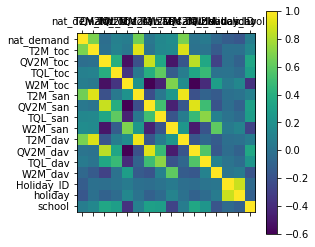

In [ ]:
cor_cols = dataset_columns
plt.matshow(dataset_train.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [ ]:
values = dataset_train.values
print(values.shape)
print(type(values))
values[0]

(43775, 16)
<class 'numpy.ndarray'>


array([9.70345000e+02, 2.58652588e+01, 1.85763820e-02, 1.61743160e-02,
       2.18505458e+01, 2.34824463e+01, 1.72717550e-02, 1.85537300e-03,
       1.03289487e+01, 2.26621338e+01, 1.65622220e-02, 9.60998500e-02,
       5.36414795e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [ ]:
# normalized the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)
print(scaled_dataset[0])
scaled_dataset.shape

[0.5409399  0.24092133 0.61321832 0.03103044 0.55688809 0.19262007
 0.59236179 0.00380735 0.42043586 0.19103092 0.61106557 0.20105082
 0.52063079 0.         0.         0.        ]


(43775, 16)

In [ ]:
def to_supervised(train):
  window_size = 48
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,1:])
    Y.append(train[i,0:1])
    
  return X,Y
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (43727, 1)
X (43727, 48, 15)


In [ ]:
X[0].shape

(48, 15)

In [ ]:
X.shape

(43727, 48, 15)

In [ ]:
#Splitting the dataset
n_train = 24*365
train_X, test_X = X[n_train:,] , X[:n_train,]
print('train_X' ,train_X.shape)
print('test_X' ,test_X.shape)

train_y, test_y = Y[n_train:,] , Y[:n_train,]
print('train_y' ,train_y.shape)
print('test_y' ,test_y.shape)

train_X (34967, 48, 15)
test_X (8760, 48, 15)
train_y (34967, 1)
test_y (8760, 1)


In [ ]:
test_X.shape

(8760, 48, 15)

In [ ]:
test_y.shape

(8760, 1)

In [ ]:
print(train_X)

[[[0.25591989 0.70528319 0.0446575  ... 0.         0.         0.        ]
  [0.24920588 0.68375298 0.04685305 ... 0.         0.         0.        ]
  [0.24375186 0.66147253 0.04727752 ... 0.         0.         0.        ]
  ...
  [0.28999237 0.67523179 0.04743853 ... 0.         0.         0.        ]
  [0.27491301 0.66308076 0.04383782 ... 0.         0.         0.        ]
  [0.26239654 0.65592261 0.04787764 ... 0.         0.         0.        ]]

 [[0.24920588 0.68375298 0.04685305 ... 0.         0.         0.        ]
  [0.24375186 0.66147253 0.04727752 ... 0.         0.         0.        ]
  [0.23703281 0.6492398  0.05052693 ... 0.         0.         0.        ]
  ...
  [0.27491301 0.66308076 0.04383782 ... 0.         0.         0.        ]
  [0.26239654 0.65592261 0.04787764 ... 0.         0.         0.        ]
  [0.25104914 0.65094138 0.06774005 ... 0.         0.         0.        ]]

 [[0.24375186 0.66147253 0.04727752 ... 0.         0.         0.        ]
  [0.23703281 0.649239

In [ ]:
train_y

array([[0.57399327],
       [0.53841191],
       [0.53565323],
       ...,
       [0.67742589],
       [0.63878884],
       [0.61068694]])

In [ ]:
train_X.shape

(34967, 48, 15)

In [ ]:
train_X.shape[2]

15

In [ ]:
model = Sequential()
model.add(LSTM(100,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=20))  
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=48, validation_data=(test_X, test_y), verbose=2, shuffle=False )

Epoch 1/20
729/729 - 18s - loss: 0.0957 - val_loss: 0.1119 - 18s/epoch - 25ms/step
Epoch 2/20
729/729 - 8s - loss: 0.0677 - val_loss: 0.1114 - 8s/epoch - 11ms/step
Epoch 3/20
729/729 - 8s - loss: 0.0594 - val_loss: 0.1101 - 8s/epoch - 11ms/step
Epoch 4/20
729/729 - 8s - loss: 0.0539 - val_loss: 0.1106 - 8s/epoch - 11ms/step
Epoch 5/20
729/729 - 8s - loss: 0.0504 - val_loss: 0.1164 - 8s/epoch - 11ms/step
Epoch 6/20
729/729 - 8s - loss: 0.0474 - val_loss: 0.1237 - 8s/epoch - 11ms/step
Epoch 7/20
729/729 - 8s - loss: 0.0460 - val_loss: 0.1259 - 8s/epoch - 11ms/step
Epoch 8/20
729/729 - 8s - loss: 0.0454 - val_loss: 0.1263 - 8s/epoch - 11ms/step
Epoch 9/20
729/729 - 8s - loss: 0.0446 - val_loss: 0.1334 - 8s/epoch - 11ms/step
Epoch 10/20
729/729 - 8s - loss: 0.0440 - val_loss: 0.1195 - 8s/epoch - 11ms/step
Epoch 11/20
729/729 - 8s - loss: 0.0434 - val_loss: 0.1284 - 8s/epoch - 11ms/step
Epoch 12/20
729/729 - 8s - loss: 0.0434 - val_loss: 0.1423 - 8s/epoch - 11ms/step
Epoch 13/20
729/729 - 8

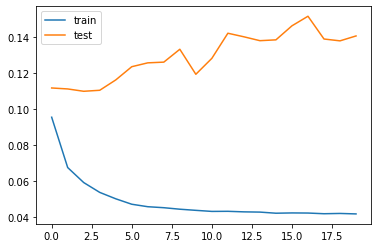

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
Y_pred = model.predict(test_X)

mse = mean_squared_error(test_y, Y_pred)

rmse = np.sqrt(mse)
rmse

274/274 [==============================] - 2s 5ms/step


0.15533714262179313

In [ ]:
d = scaled_dataset[:8760,:]
Y_predic = np.concatenate((Y_pred,d[:8760,1:]), axis =1)
# print('concat y_pred',Y_pred.shape)
print(Y_predic[0])
Y_tested = np.concatenate((test_y, d[:8760,1:]), axis = 1)
# print('concat Y_test', test_y.shape)

[0.6196419  0.24092133 0.61321832 0.03103044 0.55688809 0.19262007
 0.59236179 0.00380735 0.42043586 0.19103092 0.61106557 0.20105082
 0.52063079 0.         0.         0.        ]


In [ ]:
print(d)

[[0.5409399  0.24092133 0.61321832 ... 0.         0.         0.        ]
 [0.50539099 0.24373419 0.62044905 ... 0.         0.         0.        ]
 [0.49811449 0.24688035 0.63122022 ... 0.         0.         0.        ]
 ...
 [0.62861396 0.2775769  0.70616073 ... 0.         0.         0.        ]
 [0.60246142 0.26827476 0.71329914 ... 0.         0.         0.        ]
 [0.56354606 0.26256066 0.71682707 ... 0.         0.         0.        ]]


In [ ]:
test_y

array([[0.51538797],
       [0.49889148],
       [0.4904836 ],
       ...,
       [0.67448643],
       [0.6304452 ],
       [0.58991207]])

In [ ]:
print(Y_tested)

[[0.51538797 0.24092133 0.61321832 ... 0.         0.         0.        ]
 [0.49889148 0.24373419 0.62044905 ... 0.         0.         0.        ]
 [0.4904836  0.24688035 0.63122022 ... 0.         0.         0.        ]
 ...
 [0.67448643 0.2775769  0.70616073 ... 0.         0.         0.        ]
 [0.6304452  0.26827476 0.71329914 ... 0.         0.         0.        ]
 [0.58991207 0.26256066 0.71682707 ... 0.         0.         0.        ]]


In [ ]:
print(Y_predic)

[[0.6196419  0.24092133 0.61321832 ... 0.         0.         0.        ]
 [0.60455942 0.24373419 0.62044905 ... 0.         0.         0.        ]
 [0.59577537 0.24688035 0.63122022 ... 0.         0.         0.        ]
 ...
 [0.71897429 0.2775769  0.70616073 ... 0.         0.         0.        ]
 [0.68222857 0.26827476 0.71329914 ... 0.         0.         0.        ]
 [0.65027505 0.26256066 0.71682707 ... 0.         0.         0.        ]]


In [ ]:
Y_tested.shape

(8760, 16)

In [ ]:
d.shape

(8760, 16)

In [ ]:
d

array([[0.5409399 , 0.24092133, 0.61321832, ..., 0.        , 0.        ,
        0.        ],
       [0.50539099, 0.24373419, 0.62044905, ..., 0.        , 0.        ,
        0.        ],
       [0.49811449, 0.24688035, 0.63122022, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.62861396, 0.2775769 , 0.70616073, ..., 0.        , 0.        ,
        0.        ],
       [0.60246142, 0.26827476, 0.71329914, ..., 0.        , 0.        ,
        0.        ],
       [0.56354606, 0.26256066, 0.71682707, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
#Scaling back to the original scale
Y_predicted = scaler.inverse_transform(Y_predic)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (8760, 1)
Y_predicted (8760, 1)


In [ ]:
Y_predicted

array([[1099.12691676],
       [1074.44710724],
       [1060.0735531 ],
       ...,
       [1261.66681466],
       [1201.53892897],
       [1149.2526533 ]])

In [ ]:
print(Y_tested)

[[ 928.5338]
 [ 901.5402]
 [ 887.7822]
 ...
 [1188.8703]
 [1116.8046]
 [1050.4793]]


In [ ]:
print(Y_predicted)

[[1099.12691676]
 [1074.44710724]
 [1060.0735531 ]
 ...
 [1261.66681466]
 [1201.53892897]
 [1149.2526533 ]]


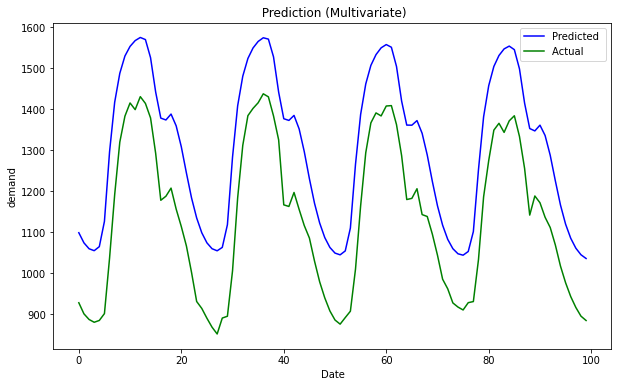

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted[:100,:], color= 'blue',label = 'Predicted ')
pyplot.plot(Y_tested[:100,:] , color = 'green',label = 'Actual ')
pyplot.title(" Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("demand")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')

In [ ]:
test_dataset=pd.read_csv("/content/Test.csv",header=0 ,index_col=0)

dec_2019=dataset_train.iloc[-48:,:]

total=pd.concat([dec_2019, test_dataset], axis=0)

print(total)

                  nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
datetime                                                                 
30-12-2019 00:00   1125.0748  26.286768  0.019728  0.062164  13.781328   
30-12-2019 01:00   1075.6192  26.246851  0.019705  0.070801  14.621861   
30-12-2019 02:00   1063.2154  26.194513  0.019652  0.081909  15.069652   
30-12-2019 03:00   1036.0259  26.152521  0.019530  0.086456  15.543580   
30-12-2019 04:00   1034.8161  26.106104  0.019385  0.081329  15.875971   
...                      ...        ...       ...       ...        ...   
31-01-2020 19:00      0.0000  26.784631  0.017690  0.010593  19.426609   
31-01-2020 20:00      0.0000  26.414575  0.017881  0.008904  17.925048   
31-01-2020 21:00      0.0000  26.165247  0.017990  0.008423  16.726263   
31-01-2020 22:00      0.0000  25.979059  0.017997  0.010746  16.620787   
31-01-2020 23:00      0.0000  25.821771  0.017967  0.016190  16.538011   

                    T2M_san  QV2M_san

In [ ]:
print(total.shape)


(792, 16)


In [ ]:
values1 = total.values
values1

array([[1.12507480e+03, 2.62867676e+01, 1.97281500e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.07561920e+03, 2.62468506e+01, 1.97051520e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.06321540e+03, 2.61945129e+01, 1.96520280e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 2.61652466e+01, 1.79896170e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.59790588e+01, 1.79973500e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.58217712e+01, 1.79670600e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaled_dataset1 = scaler1.fit_transform(values1)
print(scaled_dataset1[0])
scaled_dataset1.shape

[0.74518416 0.34159295 1.         0.22897931 0.23143627 0.30938667
 0.58504058 0.11955137 0.1614122  0.27807673 0.76829947 0.25306328
 0.08307022 0.         0.         0.        ]


(792, 16)

In [ ]:
def to_supervised(total):
  window_size = 48
  X1 = []
  Y1 = []
  for i in range(window_size, len(total)):
    X1.append(total[i-window_size:i,1:])
    Y1.append(total[i,0:1])
    
  return X1,Y1
X1, Y1 = to_supervised(scaled_dataset1)
X1 = np.array(X1)
Y1 = np.array(Y1)
print('Y1' ,Y1.shape)
print('X1' ,X1.shape)

Y1 (744, 1)
X1 (744, 48, 15)


In [ ]:
Y_pred1 = model.predict(X1)

24/24 [==============================] - 0s 5ms/step


In [ ]:
Y_pred1.shape

(744, 1)

In [ ]:
scaled_dataset1.shape

(792, 16)

In [ ]:
d = scaled_dataset1[:,:]
Y_predicted_test = np.concatenate((Y_pred1,d[48:,1:]), axis =1)
Y_predicted_test

array([[0.65944672, 0.27697384, 0.61781497, ..., 0.04545455, 1.        ,
        0.        ],
       [0.62921774, 0.25553601, 0.62310894, ..., 0.04545455, 1.        ,
        0.        ],
       [0.60305953, 0.23532473, 0.63529991, ..., 0.04545455, 1.        ,
        0.        ],
       ...,
       [0.77736127, 0.32514805, 0.60603756, ..., 0.        , 0.        ,
        0.        ],
       [0.73796308, 0.29995209, 0.60778991, ..., 0.        , 0.        ,
        0.        ],
       [0.69580615, 0.27866706, 0.600926  , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
Y_predicted_test = scaler1.inverse_transform(Y_predicted_test)
Y_predicted_test = Y_predicted_test[:,0:1]

print('Y_predicted_test', Y_predicted_test.shape)

Y_predicted_test (744, 1)


In [ ]:
Y1

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [ ]:
Y_predicted_test

array([[ 995.62889344],
       [ 949.98936316],
       [ 910.49584134],
       [ 879.82582286],
       [ 858.70634301],
       [ 846.23245478],
       [ 841.22545927],
       [ 844.05980803],
       [ 861.39850638],
       [ 904.27856021],
       [ 972.64309536],
       [1034.34444519],
       [1065.01140399],
       [1068.50169534],
       [1059.44475599],
       [1053.42149492],
       [1059.47544284],
       [1073.02094096],
       [1084.4953019 ],
       [1086.05106204],
       [1074.28747082],
       [1049.80107693],
       [1015.60108118],
       [ 976.41010828],
       [ 937.21553574],
       [ 900.07671197],
       [ 874.41152921],
       [ 861.01361593],
       [ 858.22039295],
       [ 866.686543  ],
       [ 900.09462013],
       [1001.82169709],
       [1175.85976368],
       [1279.75246811],
       [1333.59942503],
       [1361.5174363 ],
       [1379.63851425],
       [1397.6331552 ],
       [1411.09676174],
       [1382.88511065],
       [1301.65522748],
       [1239.639

In [ ]:
import sys
import numpy
np.set_printoptions(threshold=sys.maxsize)


In [ ]:
Y_predicted[744:]

array([[1107.1475964 ],
       [1078.31680525],
       [1060.14767777],
       [1051.75500932],
       [1055.08193917],
       [1088.12086597],
       [1218.90702233],
       [1379.16700136],
       [1469.29411711],
       [1519.19972289],
       [1545.59737168],
       [1561.77508133],
       [1571.9286984 ],
       [1568.47731713],
       [1513.64359106],
       [1415.74245528],
       [1365.2365372 ],
       [1383.77404479],
       [1388.59780535],
       [1360.83265389],
       [1315.2217926 ],
       [1254.56342784],
       [1193.07662234],
       [1141.1425364 ],
       [1101.60989821],
       [1074.3138779 ],
       [1058.15460188],
       [1052.34595851],
       [1060.42252425],
       [1108.22806102],
       [1250.13711207],
       [1386.32529896],
       [1463.81074451],
       [1508.61189129],
       [1533.43019691],
       [1547.30672563],
       [1552.71246239],
       [1539.72123584],
       [1477.65362452],
       [1385.90766495],
       [1339.30948254],
       [1352.825

In [ ]:
pred23=pd.read_csv("/content/Predict_Jan.csv")

In [ ]:
pred23

,datetime,nat_demand
0,01-01-2020 00:00,1032.2630
1,01-01-2020 01:00,1017.5806
2,01-01-2020 02:00,1000.2797
3,01-01-2020 03:00,987.2383
4,01-01-2020 04:00,970.3667
...,...,...
739,31-01-2020 19:00,1376.9838
740,31-01-2020 20:00,1348.6508
741,31-01-2020 21:00,1307.8774
742,31-01-2020 22:00,1250.3269


In [ ]:
a=pred23['nat_demand'].to_numpy()

In [ ]:
a.reshape(len(a),1)

array([[1032.263 ],
       [1017.5806],
       [1000.2797],
       [ 987.2383],
       [ 970.3667],
       [ 957.6767],
       [ 922.3729],
       [ 924.4692],
       [ 954.3947],
       [ 986.0648],
       [ 989.1948],
       [1005.6986],
       [1006.6785],
       [ 999.7711],
       [1000.8847],
       [1002.8859],
       [ 993.8271],
       [ 988.1441],
       [1086.8084],
       [1126.1699],
       [1130.5479],
       [1123.8589],
       [1072.263 ],
       [1076.9789],
       [1021.8683],
       [ 989.2139],
       [ 992.0821],
       [ 931.201 ],
       [ 922.7832],
       [ 958.1755],
       [ 987.5273],
       [1079.2255],
       [1237.3843],
       [1313.5203],
       [1383.2545],
       [1423.1525],
       [1446.9338],
       [1426.6427],
       [1432.75  ],
       [1387.9775],
       [1317.7584],
       [1257.317 ],
       [1308.265 ],
       [1350.8292],
       [1286.6903],
       [1261.342 ],
       [1193.7009],
       [1143.114 ],
       [1075.2017],
       [1035.1116],


In [ ]:
Y_predicted_test

array([[ 995.62889344],
       [ 949.98936316],
       [ 910.49584134],
       [ 879.82582286],
       [ 858.70634301],
       [ 846.23245478],
       [ 841.22545927],
       [ 844.05980803],
       [ 861.39850638],
       [ 904.27856021],
       [ 972.64309536],
       [1034.34444519],
       [1065.01140399],
       [1068.50169534],
       [1059.44475599],
       [1053.42149492],
       [1059.47544284],
       [1073.02094096],
       [1084.4953019 ],
       [1086.05106204],
       [1074.28747082],
       [1049.80107693],
       [1015.60108118],
       [ 976.41010828],
       [ 937.21553574],
       [ 900.07671197],
       [ 874.41152921],
       [ 861.01361593],
       [ 858.22039295],
       [ 866.686543  ],
       [ 900.09462013],
       [1001.82169709],
       [1175.85976368],
       [1279.75246811],
       [1333.59942503],
       [1361.5174363 ],
       [1379.63851425],
       [1397.6331552 ],
       [1411.09676174],
       [1382.88511065],
       [1301.65522748],
       [1239.639

In [ ]:
Y_predicted_test.shape

(744, 1)

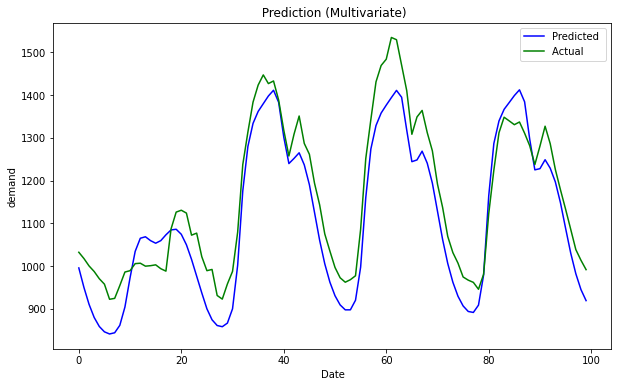

<Figure size 432x288 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted_test[:100,:], color= 'blue',label = 'Predicted ')
pyplot.plot(a.reshape(len(a),1)[:100] , color = 'green',label = 'Actual ')

pyplot.title(" Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("demand")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')

In [ ]:
!pip install hyperas
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 34.0 MB/s 
     |████████████████████████████████| 1.6 MB 50.3 MB/s 
     |████████████████████████████████| 82 kB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 31.3 MB/s 


In [ ]:
#keras_tuner_and_grid_searchCV

from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def create_model():
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(50,return_sequences=True,dropout=0.5))
    model.add(LSTM(50,dropout=0.5))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [ ]:
regressor_model = KerasRegressor(build_fn=create_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
#using_grid_search_cv
#defining the grid search parameters

batchSize=[32,64,128,256]
epochs = [10,30,50]
parameter_grid = dict(batch_size=batchSize, epochs=epochs)

In [ ]:
mygrid = GridSearchCV(estimator =regressor_model, param_grid=parameter_grid, n_jobs=1, cv=3)


In [ ]:
grid_result = mygrid.fit(train_X, train_y)

Epoch 1/10
729/729 [==============================] - 12s 11ms/step - loss: 0.0091
Epoch 2/10
729/729 [==============================] - 13s 17ms/step - loss: 0.0042
Epoch 3/10
729/729 [==============================] - 13s 18ms/step - loss: 0.0039
Epoch 4/10
729/729 [==============================] - 8s 11ms/step - loss: 0.0038
Epoch 5/10
729/729 [==============================] - 7s 10ms/step - loss: 0.0037
Epoch 6/10
729/729 [==============================] - 8s 11ms/step - loss: 0.0036
Epoch 7/10
729/729 [==============================] - 8s 11ms/step - loss: 0.0035
Epoch 8/10
729/729 [==============================] - 8s 10ms/step - loss: 0.0034
Epoch 9/10
729/729 [==============================] - 8s 10ms/step - loss: 0.0034
Epoch 10/10
365/365 [==============================] - 3s 5ms/step - loss: 0.0056
Epoch 1/10
729/729 [==============================] - 12s 11ms/step - loss: 0.0114
Epoch 2/10
729/729 [==============================] - 8s 11ms/step - loss: 0.0047
Epoch 3/10
7

In [ ]:
print(grid_result.best_params_)


{'batch_size': 128, 'epochs': 10}


In [ ]:
#to decide the number of neurons and hidden layers
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error', metrics=['mse'])
    return model

tuner = RandomSearch(build_model, 
                     objective='mse', 
                     max_trials=2, 
                     executions_per_trial=1, 
                     directory='project1', 
                     project_name='Stock_DL')

tuner.search_space_summary()

tuner.search(train_X, train_y,epochs=10,validation_split=0.2)

tuner.results_summary()

tuner.get_best_hyperparameters()[0].values

Trial 2 Complete [00h 02m 27s]
mse: 0.004627289716154337

Best mse So Far: 0.004627289716154337
Total elapsed time: 00h 05m 55s
Results summary
Results in project1/Stock_DL
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 160
n_layers: 2
lstm_0_units: 160
learning_rate: 0.0001
lstm_1_units: 320
lstm_2_units: 288
Score: 0.004627289716154337
Trial summary
Hyperparameters:
input_unit: 32
n_layers: 3
lstm_0_units: 384
learning_rate: 0.01
lstm_1_units: 32
lstm_2_units: 32
Score: 0.005907589569687843


{'input_unit': 160,
 'n_layers': 2,
 'lstm_0_units': 160,
 'learning_rate': 0.0001,
 'lstm_1_units': 320,
 'lstm_2_units': 288}

In [ ]:
model1=Sequential()
model1.add(LSTM(488,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(LSTM(288,return_sequences=True,dropout=0.5))
model1.add(LSTM(32,dropout=0.5))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
history = model1.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False )

Epoch 1/100
1093/1093 - 22s - loss: 0.0097 - val_loss: 0.0190 - 22s/epoch - 20ms/step
Epoch 2/100
1093/1093 - 17s - loss: 0.0043 - val_loss: 0.0186 - 17s/epoch - 15ms/step
Epoch 3/100
1093/1093 - 17s - loss: 0.0040 - val_loss: 0.0175 - 17s/epoch - 15ms/step
Epoch 4/100
1093/1093 - 17s - loss: 0.0039 - val_loss: 0.0178 - 17s/epoch - 15ms/step
Epoch 5/100
1093/1093 - 17s - loss: 0.0038 - val_loss: 0.0177 - 17s/epoch - 15ms/step
Epoch 6/100
1093/1093 - 17s - loss: 0.0037 - val_loss: 0.0178 - 17s/epoch - 15ms/step
Epoch 7/100
1093/1093 - 17s - loss: 0.0037 - val_loss: 0.0173 - 17s/epoch - 16ms/step
Epoch 8/100
1093/1093 - 17s - loss: 0.0036 - val_loss: 0.0179 - 17s/epoch - 15ms/step
Epoch 9/100
1093/1093 - 17s - loss: 0.0036 - val_loss: 0.0176 - 17s/epoch - 15ms/step
Epoch 10/100
1093/1093 - 17s - loss: 0.0035 - val_loss: 0.0180 - 17s/epoch - 15ms/step
Epoch 11/100
1093/1093 - 17s - loss: 0.0035 - val_loss: 0.0184 - 17s/epoch - 15ms/step
Epoch 12/100
1093/1093 - 17s - loss: 0.0035 - val_lo

In [ ]:
train_predict1=model1.predict(test_X)
# test_predict1=model1.predict(test_y)

274/274 [==============================] - 3s 6ms/step


In [ ]:
train_predict1

array([[0.62906414],
       [0.61393243],
       [0.6042297 ],
       [0.59965956],
       [0.60273844],
       [0.62021214],
       [0.6581386 ],
       [0.70949477],
       [0.75660473],
       [0.7917097 ],
       [0.8155697 ],
       [0.8315618 ],
       [0.8414097 ],
       [0.83525926],
       [0.8102197 ],
       [0.776286  ],
       [0.756596  ],
       [0.75840694],
       [0.7657749 ],
       [0.75932586],
       [0.7374465 ],
       [0.7061906 ],
       [0.6720766 ],
       [0.64277375],
       [0.6216962 ],
       [0.6078137 ],
       [0.5993853 ],
       [0.59599805],
       [0.60110503],
       [0.6247255 ],
       [0.6758041 ],
       [0.7412732 ],
       [0.7956378 ],
       [0.82953805],
       [0.84526753],
       [0.8482567 ],
       [0.8420815 ],
       [0.8207329 ],
       [0.77774614],
       [0.7301376 ],
       [0.7159314 ],
       [0.7235444 ],
       [0.72963583],
       [0.7253946 ],
       [0.7094879 ],
       [0.6835518 ],
       [0.6542885 ],
       [0.629

In [ ]:
d = scaled_dataset[:8760,:]
Y_predic1 = np.concatenate((train_predict1,d[:8760,1:]), axis =1)

In [ ]:
Y_predicted = scaler.inverse_transform(Y_predic1)


In [ ]:
Y_predicted = Y_predicted[:,0:1]


In [ ]:
Y_predicted.shape

(8760, 1)

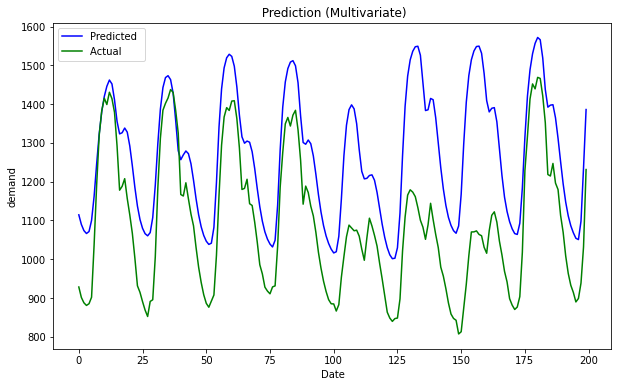

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted[:100,:], color= 'blue',label = 'Predicted ')
pyplot.plot(Y_tested[:100,:] , color = 'green',label = 'Actual ')
pyplot.title(" Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("demand")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')